In [1]:
import pandas as pd
import numpy as np

### Importing the dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab\ Notebooks/ECE \1786/project/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/ECE 1786/project


In [3]:
df = pd.read_csv('Dataset/ToS-100-cleaned.csv',header=0,encoding='utf-8')
# A, CH, CR, J, LAW, LTD, PINC, TER, USE
data = df[['text', 'fair']]
data

,text,fair
0,websites & communications terms of use,1
1,please read the terms of this entire document ...,1
2,by accessing or signing up to receive communic...,0
3,our websites include multiple domains such as ...,1
4,you may also recognize our websites by nicknam...,1
...,...,...
20412,you may terminate your account at our service ...,1
20413,the following provisions shall survive termina...,1
20414,"the company reserves the right , at its sole d...",0
20415,"your continued use of the service , following ...",0


## Reading the dataset

In [4]:
text = []
labels = []

for index, row in data.iterrows():
    text.append(row['text'])
    labels.append(row['fair'])

#### HyperParameter

In [5]:
embd_size = 64

## Tokenization and Embedding

In [6]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk

nltk.download('punkt')

# Tokenize the sentences
tokenized_sentences = [word_tokenize(tos.lower()) for tos in text]

# Train the Word2Vec model
embedding = Word2Vec(sentences=tokenized_sentences, vector_size=embd_size, window=5, min_count=1, workers=4)

# Save the model
embedding.save("word2vec_model_tos")

# Access word embeddings
word_embeddings = embedding.wv
tos_embeddings = [[word_embeddings[word] for word in tos] for tos in tokenized_sentences]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


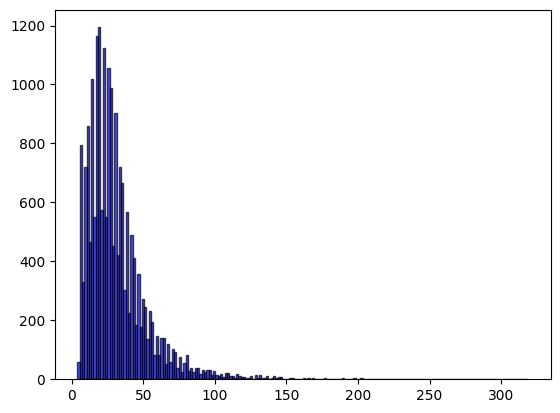

number of sentences longer than 128: 183
number of fair sentences: 18239
number of unfair sentences: 2178


In [7]:
import matplotlib.pyplot as plt

# collect the length of sentences
# used to decide on a practical sequence_length for training
length_data = [len(tos) for tos in tokenized_sentences]

plt.hist(length_data, bins='auto', alpha=0.7, color='blue', edgecolor='black')
plt.show()

# no of sentences longer than threshold
threshold = 128
print(f"number of sentences longer than {threshold}: {len([l for l in length_data if l > threshold])}")

# no of fair sentences
print(f"number of fair sentences: {len([fair for fair in labels if fair == 1])}")

# no of unir sentences
print(f"number of unfair sentences: {len([fair for fair in labels if fair == 0])}")

* No of sentences longer than 128 is just 183. Taking the sequence length for training to be 128.

#### HyperParameter

In [8]:
max_length = 128

## Clean the dataset

* Crop sentences longer than seq_length.
* Add padding to the beginning of other sentences.
* Fix the class imbalance between fair and unfair sentences.

In [9]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import torch

def crop_and_pad(sentence, seq_length=max_length):
    length = len(sentence)

    if length > seq_length:
        new_sentence = sentence[:seq_length]
    else:
        new_sentence = [np.zeros(embd_size)]*(seq_length - length) + sentence

    return new_sentence

# crop and pad
processed_embeddings = np.stack([crop_and_pad(tos) for tos in tos_embeddings], axis = 0)

# class balancing
smote = SMOTE(sampling_strategy='auto', random_state=42)

indices = [[i] for i in range(len(labels))] # smote requires 2-D array!

indices, labels = smote.fit_resample(indices, labels) # smote cannot work on text data, so passing indices

processed_embeddings = [torch.tensor(processed_embeddings[i[0]], dtype=torch.float32) for i in indices]
labels = torch.tensor(labels, dtype=torch.float32)

# make sure class balance is achieved
print("After SMOTE sampling")
print(f"number of fair sentences: {len([fair for fair in labels if fair == 1])}")
print(f"number of unfair sentences: {len([fair for fair in labels if fair == 0])}")

dataset = list(zip(processed_embeddings, labels))

# Split the data into training and testing sets
train_dataset, test_dataset = train_test_split(dataset, test_size=0.1, random_state=42)

After SMOTE sampling
number of fair sentences: 18239
number of unfair sentences: 18239


#### HyperParameter

In [10]:
batch_size = 128

In [11]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## Classification_model

#### model_parameters

In [12]:
n_layers = 4
hidden_size = 256
lr = 1e-2

In [13]:
import torch.nn as nn

# Define the GRU-based model
class GRUClassifier(nn.Module):
    def __init__(self, embedding_dim=embd_size, hidden_dim=hidden_size, n_layers=n_layers):
        super(GRUClassifier, self).__init__()
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        output, _ = self.gru(x)
        last_hidden_state = output[:, -1, :]
        logits = self.fc(last_hidden_state)
        return self.sigmoid(logits)

In [14]:
import torch.optim as optim

# Instantiate the model, criterion, and optimizer
model = GRUClassifier()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model = model.to(device)

In [16]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for tos, labels in train_loader:

        tos, labels = tos.to(device), labels.to(device)

        # Forward pass
        logits = model(tos)

        # Calculate loss
        loss = criterion(logits.squeeze(), labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate the model (you should have a separate validation set)
    with torch.no_grad():
        model.eval()

        accuracy = 0
        for i, data in enumerate(test_loader):
            tos, labels = data
            tos, labels = tos.to(device), labels.to(device)
            # Forward pass
            logits = model(tos)
            predictions = (logits.squeeze() > 0.5).float()
            batch_accuracy = (predictions == labels).float().mean()
            accuracy += batch_accuracy.item()
        print(f'Epoch {epoch + 1}/{num_epochs}, Accuracy: {accuracy/i*100:.2f}%')

Epoch 1/10, Accuracy: 71.01%
Epoch 2/10, Accuracy: 70.65%
Epoch 3/10, Accuracy: 71.93%
Epoch 4/10, Accuracy: 68.05%
Epoch 5/10, Accuracy: 72.24%
Epoch 6/10, Accuracy: 72.35%
Epoch 7/10, Accuracy: 71.23%
Epoch 8/10, Accuracy: 73.16%
Epoch 9/10, Accuracy: 72.85%
Epoch 10/10, Accuracy: 72.68%
